In [1]:
import os
import glob
import random
import shutil # shell utilities
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm # progress indicator

In [3]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

# Just use 20 files.
file_number = 20

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):

    # Create all the folders.
    for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
        if not os.path.exists(path):
            os.mkdir(path)

    # Clone the repo.
    #!git clone https://github.com/vilmibm/lovecraftcorpus
        
    # Find all the files.
    #paths_all = glob.glob("lovecraftcorpus/*.txt")
    
    print(sorted(paths_all))

    # Do not use all.
    paths_all = paths_all[:file_number]

    # Split 80/20.
    split_index = int(len(paths_all) * 0.8)
    paths_train = paths_all[:split_index]
    paths_valid = paths_all[split_index:]

    # Copy files.
    def copy(paths, destination):
        for path in paths:
            shutil.copy2(path, destination)
    copy(paths_all, dataset_path_all)
    copy(paths_train, dataset_path_train)
    copy(paths_valid, dataset_path_valid)

    # Delete repo.
    !rm -rf lovecraftcorpus

    # Done.
    print("Corpus downloaded.")



In [4]:
!ls dataset
print("")
!ls dataset/all
print("")
!ls dataset/train
print("")
!ls dataset/valid


all  train  valid

'(Book) - Cookbook - Nelson Family Recipe Book_djvu.txt'
'Cookbook - Fish & Game Recipes_djvu.txt'
'Cookbook - Fish Recipes_djvu.txt'
'Cooking - 200 Recipes for Italian Dishes_djvu.txt'
'Cooking - Soup Recipes_djvu.txt'
'(ebook) Food - Vegetable Recipes_djvu.txt'
'(ebook-pdf) - Cooking - Italian Recipes_djvu.txt'
'(ebook-pdf) - Cooking - Low Fat Recipes_djvu.txt'
'(ebook-pdf) - Cooking - Salad Recipes (1)_djvu.txt'
'E-Cookbooks Italian Recipe Sampler_djvu.txt'
'E-Cookbooks Low Fat Recipe Sampler_djvu.txt'
'E-Cookbooks Salads Recipes_djvu.txt'
'Italian Recipes_djvu.txt'
'Lifestyle to Health - Vegan  Cookbook Recipes, vegetarian health book_djvu.txt'

'(Book) - Cookbook - Nelson Family Recipe Book_djvu.txt'
'Cookbook - Fish & Game Recipes_djvu.txt'
'Cookbook - Fish Recipes_djvu.txt'
'Cooking - 200 Recipes for Italian Dishes_djvu.txt'
'Cooking - Soup Recipes_djvu.txt'
'(ebook) Food - Vegetable Recipes_djvu.txt'
'(ebook-pdf) - Cooking - Italian Recipes_djvu.txt'
'(ebook-

## Prepare datasets

In [5]:
batch_size = 32
seed = 42

def create_dataset(dataset_path):
  dataset = preprocessing.text_dataset_from_directory( # turns file system into dataset
      dataset_path, 
      labels=None,
      batch_size=batch_size,
      seed=seed
  )
  return dataset

dataset_original_all = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)


Found 14 files belonging to 1 classes.
Found 11 files belonging to 1 classes.
Found 3 files belonging to 1 classes.


In [6]:
# check if files work
for batch in dataset_original_all:
  for sample in batch[:4]:
    sample = sample.numpy()
    print(sample[:200], "...")
    print(len(sample), "bytes")
    print("")

b'\nTHE FOOD AND COOKING NETWORK \n\n\n\nE-Cookbooks Soup Recipe Sampler \n\nVJJE Publishing Co. \n\n\n\nE-Cookbooks Soup Recipe Sampler \n\nTable of Contents \n\nIntroduction 1 \n\nPersonalized Cooking Aprons 2 \n\nBasic' ...
22103 bytes

b'Vegetable (loosely) Recipes \n\nVegetable (loosely) Recipes \n\n\n\nIndex \n\n\n\n\xe2\x80\xa2 \n\n\nGreen/Red Peppers : INDEX \n\n\n\xe2\x80\xa2 \n\n\nMushrooms : INDEX \n\n\n\xe2\x80\xa2 \n\n\nPotatoes : INDEX \n\n\n\xe2\x80\xa2 \n\n\nSpinach : INDEX \n\n\n\xe2\x80\xa2 \n\n\nVege' ...
260275 bytes

b'Cooking - 200 Recipes for Italian Dishes (Share Me).txt \nThe Cook\'s Decameron: A Study In Taste \n\nContaining Over Two Hundred Recipes For Italian Dishes \n\nBy \n\nMrs. w. G. waters \n\n"Show me a pleasure ' ...
270098 bytes

b'Nelson Family \nRecipe Book \n\nTable Of Contents \n\n\n\nBreads 3 \n\nSoups 15 \n\nVegetables 23 \n\nSalads 29 \n\nMain Dishes 39 \n\nCake & Frostings 65 \n\nCookies, Bars, and Lefse 75 \n\nPies & Desserts 93 \n\nBeverage

## Create the tokenizer

In [13]:
vocabulary_size = 10000 # 10.000 is very limited, just for exercise shake

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int" # word indices with respect to vocabulary | no sequence length!
)
encoder.adapt(dataset_original_all) # we cannot batch

vocabulary = encoder.get_vocabulary()

print(f"Vocabulary size: {len(vocabulary)}")
print(f"Vocabulary: {vocabulary}")

Vocabulary size: 9936
Vocabulary: ['', '[UNK]', 'and', 'the', 'a', '1', 'of', 'in', 'to', 'with', '2', 'cup', 'or', 'for', 'add', '12', 'salt', 'until', 'minutes', 'it', 'c', 'water', 'sauce', 'pepper', 'butter', 'into', 'chopped', 'on', 'i', 'is', 'teaspoon', 'o', '14', 'over', '3', 'tsp', 'cheese', 'ingredients', 'oil', 'cups', 'garlic', 'onion', 'flour', 'heat', 'at', 'cook', 'them', 'mix', 'from', 'as', 'sugar', 'you', 'then', 'cut', '4', 'about', 'this', 'all', 'cream', 'large', 'bake', 'mixture', 'serve', 'be', 'pan', 'that', 'well', 'can', 'vi', 'put', 'no', 'stir', 'juice', 'chicken', 'tablespoons', 'if', 'eggs', 'are', 'place', 'salad', 'bowl', 'an', 'pour', 'mushrooms', 'fresh', 'one', 'cooking', 'bread', 'potatoes', 'small', 'parsley', 'milk', 'up', 'lemon', 'brown', 'hot', 'tomatoes', 'egg', 'boil', 'stock', 'when', 'cover', 'two', 'cooked', 'taste', 'recipes', 'alia', 'powder', 'oven', 'half', 'onions', 'combine', 'fish', 'dish', 'oz', 'top', 'olive', 'little', '5', 'have'

## Prepare data for autoregression

In [16]:
# compromise on sequence length to have same-size batches
sequence_length = 32 # GPT uses 2200...

def create_dataset_for_autoregression(dataset):
    x_inputs = []
    y_outputs = []
    for samples in dataset: # Get a batch, should be all the books
        samples = encoder(samples).numpy()
        for sample in tqdm(samples): # Go through each of the books

            # Pad at the beggining of each book
            padding_token_id = vocabulary.index("")
            padding = [padding_token_id] * sequence_length
            sample = padding + list(sample)

            # Map to input output pairs
            for start_index in range(0, len(sample) - sequence_length):
                x = sample[start_index:start_index + sequence_length]
                y = sample[start_index + sequence_length]
                x_inputs += [x] # append
                y_outputs += [y]

    return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))


dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)

100%|██████████| 3/3 [00:00<00:00,  7.06it/s]


In [17]:
# visualise how autoregression works

def decode(indices):
    return " ".join([vocabulary[index] for index in indices if vocabulary[index] is not ""])

for input, output  in dataset_train.take(10):
    print("input: ", " ".join([str(x) for x in input.numpy()]))
    print("output:", output.numpy())
    print("input decoded: ", decode(input))
    print("output decoded:", decode([output]))
    print("")

input:  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
output: 105
input decoded:  
output decoded: recipes

input:  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 105
output: 2176
input decoded:  recipes
output decoded: septemberoctober

input:  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 105 2176
output: 2300
input decoded:  recipes septemberoctober
output decoded: 1997

input:  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 105 2176 2300
output: 2288
input decoded:  recipes septemberoctober 1997
output decoded: backwoods

input:  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 105 2176 2300 2288
output: 1048
input decoded:  recipes septemberoctober 1997 backwoods
output decoded: home

input:  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 105 2176 2300 2288 1048
output: 1899
input decoded:  recipes septemberoctober 1997 backwoods home
output decoded: magazine

input:  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [18]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

## LSTM

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 128)           1280000   
                                                                 
 dropout_6 (Dropout)         (None, 32, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 32, 512)           1312768   
                                                                 
 dropout_7 (Dropout)         (None, 32, 512)           0         
                                                                 
 lstm_5 (LSTM)               (None, 1024)              6295552   
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 10000)            

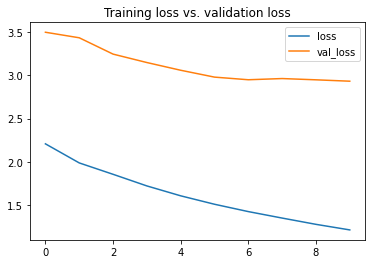

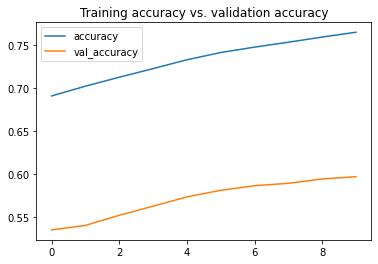

In [33]:
from tensorflow.keras import models, layers

embedding_size = 128

model = models.Sequential()
# no need of encoding layer, as data already encoded
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length)) 
model.add(layers.Dropout(0.3)) # dropout activations
model.add(layers.LSTM(512, return_sequences=True))
model.add(layers.Dropout(0.4))
model.add(layers.LSTM(1024))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(vocabulary_size, activation="softmax")) # 10.000 words, word with highest activation will be the predicted
model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy", # avoids having to implement one-hot encoder
    metrics=["accuracy"]
)

# train
history = model.fit(
    dataset_train.shuffle(10000).batch(512),
    epochs=10,
    validation_data=dataset_valid.batch(512)
)

render_history(history)

## Text Generation

In [20]:
import numpy as np

def generate(model, seed_text, generated_sequence_length, temperature):

    input_sequence = encoder(seed_text).numpy()

    generated_sequence = list(input_sequence[::])

    # Pad.
    padding = [0] * (sequence_length - len(input_sequence))
    input_sequence = padding + list(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(generated_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0))
        predicted_index = get_index_from_prediction(prediction[0], temperature)
        generated_sequence.append(predicted_index)
        input_sequence = input_sequence[1:]
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(generated_sequence)
    print(text)
    print("")

        
def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)
  

In [21]:
generate(model, "eggs flour butter sugar", 100, temperature=1.0)

eggs flour butter sugar 12 cup olive oil saute everything 4 over a mornings layer let heat 5 minutes stirring occasionally and deglaze bottom 14 rack in butter drippings cover with wine set aside to oven till golden browned grease heat add to a large pinch of salt and pepper to taste about 24 tablespoons of fat scoop it over the sauce after mediumlow sauce 3 cups the bread low off oven from a rack combine all a mushroom brown mushrooms wide ingredients the cream salt and pepper until the lightly it forms brown when the sauce is goose this



In [23]:
generate(model, "boil the rice in coconut milk", 100, temperature=1.0)

boil the rice in coconut milk saute in the rice roast done 1 tablespoon water over one side mix well over covered with the refrigerator line the entire paper dish and come out stir in zucchini pour the top of three hens of marinade and brown celery brown sauce to the cavity of the flavors garni adding the crisp crust venison venison carp with mushrooms stew sampler roux with the sauce cups 3 ingredients water and blacken dry and then cover with the eggs to a garnish to discard grated brown add a few inch thick pan puree cornstarch lemon



In [37]:
generate(model, "add the ingredients to", 30, temperature=1.0)

add the ingredients to the 2 medium slices of tomatoes packed ecookbooks flour and fork slices 23 medium firm sauce and allpurpose sausage together up reserve a couple ounces of



In [35]:
generate(model, "chop the onions and cut ", 30, temperature=1.0)

chop the onions and cut up food 3 game possum 2 pounds beef and dried fresh spinach 3 eggs cut into 1inch pieces 5 oz gravy cut into 1inch pieces

